In [6]:
import torch
import numpy as np
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim

single_layer = False #whether to fit single layer or full structure

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

In [7]:
set_random_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Auxillary functions initialization 

In [8]:
def u2mzi(
    dim, m, n, theta, phi,
    lp=torch.tensor(1, dtype=torch.complex128),
    lc=torch.tensor(1, dtype=torch.complex128),
):
    assert m < n < dim
    mat = torch.eye(dim, dtype=torch.complex128).to(theta.device)
    sqrt_lp = torch.sqrt(lp).to(phi.device)
    sqrt_lc = torch.sqrt(lc).to(phi.device)
    phase = torch.exp(1j * theta)

    mat[m, m] = sqrt_lp * phase * torch.sin(phi)
    mat[m, n] = sqrt_lc * phase * torch.cos(phi)
    mat[n, m] = sqrt_lc * torch.cos(phi)
    mat[n, n] = -sqrt_lp * torch.sin(phi)
    return mat

def angle_diff(
        comp_src, comp_dst, offset=0, tolerance=torch.tensor(1e-6),
        wrap=True, to_degree=False
    ):
    zero_src = torch.abs(comp_src) <= tolerance
    zero_dst = torch.abs(comp_dst) <= tolerance

    rad = torch.where(
        zero_src & zero_dst, torch.tensor(0.),
        torch.where(
            zero_src, torch.angle(comp_dst),
            torch.where(
                zero_dst, -torch.angle(comp_src),
                torch.angle(comp_src) - torch.angle(comp_dst)
            )
        )
    )
    rad = torch.remainder(rad + offset, 2 * torch.pi) if wrap else rad + offset
    return torch.rad2deg(rad) if to_degree else rad

# Reck unitary class initialization

In [9]:
import numpy as np
import torch.nn as nn

class ReckUnitaryLayer(nn.Module):
    def __init__(self, dim=4, lp_db=0, lc_db=0):
        super().__init__()
        self.dim = dim
        self.num = int(dim * (dim - 1) / 2)

        self.lp = 10 ** (lp_db / 10)
        self.lc = 10 ** (lc_db / 10)

        self.lp = torch.tensor(self.lp, dtype=torch.float64)
        self.lc = torch.tensor(self.lc, dtype=torch.float64)

        self.phis = nn.Parameter(
            torch.rand(self.num, dtype=torch.float64)*2*torch.pi
        )
        self.thetas = nn.Parameter(
            torch.rand(self.num-3, dtype=torch.float64)*2*torch.pi
        )
        self.thetas_constant = torch.zeros(3, dtype=torch.float64, device=self.phis.device)

        self.register_buffer("alphas", torch.zeros(self.dim, dtype=torch.float64))
        self.q_list, self.p_list = self.get_q_p()

    def get_q_p(self):
        q_list, p_list = [], []
        for p in range(1, self.dim):
            for q in range(p):
                q_list.append(q)
                p_list.append(p)
        return q_list, p_list
    
    def theta_concat(self):
        return torch.cat([self.thetas_constant.to(self.thetas.device), self.thetas])
    
    def reconstruct(self, phis, thetas, alphas):
        self.mat = torch.diag(torch.exp(-1j * alphas)).to(torch.complex128)
        for q, p, theta, phi in zip(
            self.q_list, self.p_list,
            thetas.flip(0), phis.flip(0)
        ):
            self.mat = self.mat @ u2mzi(
                self.dim, q, p, theta, phi, lp=self.lp, lc=self.lc
            ).conj().T
        return self.mat    

    def decompose(self, u):
        index = 0
        phis = torch.zeros(self.num, device=u.device)
        thetas = torch.zeros(self.num, device=u.device)
        alphas = torch.zeros(self.dim, device=u.device)
        mat = torch.clone(u).to(torch.complex128)
        for x, y in zip(self.p_list[::-1], self.q_list[::-1]):
            phis[index] = torch.atan2(
                torch.abs(mat[x, x]), torch.abs(mat[x, y])
            )
            thetas[index] = angle_diff(mat[x, x], mat[x, y], offset=torch.pi)
            mat = mat @ u2mzi(
                self.dim, y, x, thetas[index], phis[index],
            )
            index += 1

        for i in range(self.dim):
            alphas[i] = -torch.angle(mat[i, i])

        return phis, thetas, alphas

    def forward(self):
        return self.reconstruct(self.phis, self.theta_concat(), self.alphas)

# Data load

In [27]:
data = []
data_no_current = []

if single_layer:
    file_path = "Calibration Example_915"
else:
    file_path = "full-structure-data"

for ch in range(4):
    for H in range(3):
        with open(
            # start with +1 in case of a single layer and with +5,+9 or +14 to the incdeces in case of the full structure
            file_path+f"/ch{ch + 1}_H{H + 9}.txt"
        ) as file:
            for line in file:
                try:
                    row = [float(num) for num in line.split()]
                    data.append([ch,H] + row)
                    if row[0] == 0:
                        data_no_current.append([ch,H] + row)
                except:
                    pass

In [28]:
df = pd.DataFrame(
    data, columns=['in_ch', 'heater', 'current', 'ch1', 'ch2', 'ch3', 'ch4'],
)

"""Normalize the channels to sum to 1 for each row."""
cols_to_normalize = ['ch1', 'ch2', 'ch3', 'ch4']
df[cols_to_normalize] = df[cols_to_normalize].div(
    df[cols_to_normalize].sum(axis=1), axis=0
)

if single_layer:
    current_coefficient = 10**(-3)
else:
    current_coefficient = 10**1
df["power"] = (current_coefficient * df["current"]) ** 2

df.tail()

,in_ch,heater,current,ch1,ch2,ch3,ch4,power
955,3,2,0.076,0.486916,0.266290,0.138633,0.108162,0.5776
956,3,2,0.077,0.449453,0.289417,0.148294,0.112835,0.5929
957,3,2,0.078,0.415702,0.310192,0.156255,0.117851,0.6084
958,3,2,0.079,0.384530,0.326923,0.164029,0.124518,0.6241
959,3,2,0.080,0.360032,0.335934,0.173502,0.130532,0.6400


In [29]:
#data tensors
ind = torch.tensor(df["heater"].values) 

x_all = torch.zeros((len(df), 3), dtype=torch.float64)
x_all[torch.arange(len(data)), ind] = torch.tensor(df["power"].values)

target = [np.expand_dims(df[i].values, axis=1) for i in ['ch1', 'ch2', 'ch3', 'ch4']] 
target = np.concatenate(target, axis=1)
target = torch.tensor(target, dtype=torch.float64)

indx = torch.tensor(df["in_ch"].values, device=device)
indx = indx.unsqueeze(-1).unsqueeze(-1)
indx = indx.expand(-1, -1, 4)

# Phase shift layer initialization - credits to Gemini for implementation of physical constrains (see project description)

In [ ]:
def inv_sigmoid(x):
    x = np.clip(x, 1e-6, 1 - 1e-6)
    return np.log(x / (1 - x))

class Structure(nn.Module):
    def __init__(self, dim=4, lp_db=0, lc_db=0):
        super().__init__()
        self.dim = dim
        self.m1 = ReckUnitaryLayer(dim, lp_db, lc_db)
        self.m2 = ReckUnitaryLayer(dim, lp_db, lc_db)

        # --- 1. Unitary Initialization (Mixing) ---
        with torch.no_grad():
            self.m1.phis.data.fill_(torch.pi / 4.0) 
            self.m2.phis.data.fill_(torch.pi / 4.0)
            self.m1.thetas.data.fill_(0.0)
            self.m2.thetas.data.fill_(0.0)

        # --- 2. Constrained Alpha Initialization ---
        r0 = inv_sigmoid(0.95)
        r1 = inv_sigmoid(0.7894)
        r2 = inv_sigmoid(0.5294)
        self.raw_diag = nn.Parameter(torch.tensor([r0, r1, r2], dtype=torch.float64))
        
        self.raw_matrix = nn.Parameter(torch.full((3, 3), inv_sigmoid(0.4), dtype=torch.float64))
        
        # --- 3. Physical Corrections Parameters ---

        self.h_0 = nn.Parameter(torch.zeros(3, dtype=torch.float64))
        
        self.beta = nn.Parameter(torch.zeros((3,3), dtype=torch.float64))

        self.in_log_eff = nn.Parameter(torch.zeros(dim, dtype=torch.float64))
        self.out_log_eff = nn.Parameter(torch.zeros(dim, dtype=torch.float64))
        
        self.background = nn.Parameter(torch.full((dim,), 0.001, dtype=torch.float64))

    def get_constrained_alpha(self):
        sigmoid = torch.sigmoid
        
        # Diagonals
        a00 = 10.0 * sigmoid(self.raw_diag[0]) + 1e-6
        a11 = a00 * (0.5 + 0.5 * sigmoid(self.raw_diag[1]))
        a22 = a11 * (0.5 + 0.5 * sigmoid(self.raw_diag[2]))
        diag_values = torch.stack([a00, a11, a22])
        
        # Off-Diagonals
        lower_bound = -4.0 
        upper_bound = a22 
        constrained_matrix = lower_bound + (upper_bound - lower_bound) * sigmoid(self.raw_matrix)
        
        eye = torch.eye(3, device=self.raw_diag.device, dtype=self.raw_diag.dtype)
        alpha = (1 - eye) * constrained_matrix + torch.diag_embed(diag_values)
        return alpha

    def forward(self, x, indx, bottom_heaters=True):
        alpha = self.get_constrained_alpha()
        
        if bottom_heaters:
            alpha_val = alpha.to(x.device)
            beta_val = self.beta.to(x.device)
        else:
            alpha_val = alpha.to(x.device).flip([0,1])
            beta_val = self.beta.to(x.device).flip([0,1])
        h_0_val = self.h_0.to(x.device)
        
        h_list = h_0_val + (alpha_val @ x.T).T + (beta_val @ (x**2).T).T
        
        if bottom_heaters:
            h_diag = torch.cat([
                torch.ones((x.shape[0], 1), dtype=torch.complex128, device=x.device),
                torch.exp(1j * h_list),
            ], dim=1)
        else:
            h_diag = torch.cat([
                torch.exp(1j * h_list),
                torch.ones((x.shape[0], 1), dtype=torch.complex128, device=x.device)
            ], dim=1)


        m1 = self.m1()
        m2 = self.m2()
        
        # --- Apply Coupling Efficiencies ---
        in_gain = torch.diag(torch.exp(self.in_log_eff))
        out_gain = torch.diag(torch.exp(self.out_log_eff))
        middle_term = m2 @ torch.diag_embed(h_diag) @ m1
        
        in_gain_c = in_gain.to(torch.complex128)
        out_gain_c = out_gain.to(torch.complex128)
        
        total_transfer = out_gain_c @ middle_term @ in_gain_c
        
        predict = torch.abs(total_transfer) ** 2

        predict = predict + torch.abs(self.background).unsqueeze(0).unsqueeze(0)
        
        predict = torch.gather(predict, dim=1, index=indx)
        
        return predict.squeeze(1)
    
    def get_full_matrix(self, x, bottom_heaters=True):
        alpha = self.get_constrained_alpha()
        alpha_val = alpha.to(x.device).flip(0)
        beta_val = self.beta.to(x.device).flip(0)
        h_0_val = self.h_0.to(x.device)
        
        h_list = h_0_val + (alpha_val @ x.T).T + (beta_val @ (x**2).T).T
        
        if bottom_heaters:
            h_diag = torch.cat([torch.ones((x.shape[0], 1), dtype=torch.complex128, device=x.device), torch.exp(1j * h_list)], dim=1)
        else:
            h_diag = torch.cat([torch.exp(1j * h_list), torch.ones((x.shape[0], 1), dtype=torch.complex128, device=x.device)], dim=1)

        m1 = self.m1()
        m2 = self.m2()
        
        in_gain = torch.diag(torch.exp(self.in_log_eff)).to(torch.complex128)
        out_gain = torch.diag(torch.exp(self.out_log_eff)).to(torch.complex128)
        
        middle_term = m2 @ torch.diag_embed(h_diag) @ m1
        total_transfer = out_gain @ middle_term @ in_gain
        
        power_matrix = torch.abs(total_transfer) ** 2
        power_matrix = power_matrix + torch.abs(self.background).view(1, 4, 1)
        
        return power_matrix

# Optimization

In [ ]:
from tqdm import tqdm
import torch.optim as optim

print('Select wether to fit a single layer or a full structure:')
single_layer = input('Are you fitting a single layer? (y/n)').strip().startswith('y')

model = Structure().to(device)

x_all = x_all.to(device)
target = target.to(device)
indx = indx.to(device)

optimizer_adam = optim.AdamW(model.parameters(), lr=0.02, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_adam, T_max=300, eta_min=1e-4)

print("Phase 1: Exploration with Mixing Initialization...")
pbar = tqdm(range(400))
for step in pbar:
    optimizer_adam.zero_grad()
    pred = model(x_all, indx, bottom_heaters=single_layer)
  
    loss = nn.functional.mse_loss(pred, target)
    
    loss.backward()
    optimizer_adam.step()
    scheduler.step()
    
    if step % 10 == 0:
        pbar.set_description(f"AdamW Loss: {loss.item():.6f}")

optimizer_lbfgs = optim.LBFGS(
    model.parameters(), 
    lr=0.001, 
    max_iter=50, 
    history_size=100,
    line_search_fn="strong_wolfe",
    tolerance_grad=1e-9,
    tolerance_change=1e-9
)

print("\nPhase 2: LBFGS Precision Fitting...")
def closure():
    optimizer_lbfgs.zero_grad()
    pred = model(x_all, indx, bottom_heaters=True)
    loss = nn.functional.mse_loss(pred, target)
    loss.backward()
    return loss

pbar_lbfgs = tqdm(range(100))
best_loss = float('inf')

for step in pbar_lbfgs:
    loss = optimizer_lbfgs.step(closure)
    pbar_lbfgs.set_description(f"LBFGS Loss: {loss.item():.8f}")
    
    if loss.item() < best_loss:
        best_loss = loss.item()

    if step > 20 and loss.item() > best_loss - 1e-9:
        print("Converged (Loss plateau).")
        break

print(f"Final Best Loss: {best_loss}")

torch.save(model.state_dict(), "best_model.pth")

with torch.no_grad():
    alpha_final = model.get_constrained_alpha()
    print("\nFinal Alpha Matrix:")
    print(alpha_final)
    print("\nConstraint Checks:")
    print(f"a00 ({alpha_final[0,0]:.4f}) > a11 ({alpha_final[1,1]:.4f}): {alpha_final[0,0] > alpha_final[1,1]}")
    print(f"a11 ({alpha_final[1,1]:.4f}) > a22 ({alpha_final[2,2]:.4f}): {alpha_final[1,1] > alpha_final[2,2]}")

Phase 1: Exploration with Mixing Initialization...


  0%|          | 0/400 [00:00<?, ?it/s]

AdamW Loss: 0.002175: 100%|██████████| 400/400 [00:15<00:00, 25.30it/s]



Phase 2: LBFGS Precision Fitting...


LBFGS Loss: 0.00031763:  21%|██        | 21/100 [01:14<04:40,  3.55s/it]

Converged (Loss plateau).
Final Best Loss: 0.0003176267276079226

Final Alpha Matrix:
tensor([[ 8.6706, -2.3896,  4.8475],
        [-3.9979,  8.4055,  4.8267],
        [ 2.6016,  3.8761,  4.8476]], device='cuda:0', dtype=torch.float64)

Constraint Checks:
a00 (8.6706) > a11 (8.4055): True
a11 (8.4055) > a22 (4.8476): True


# Plot data

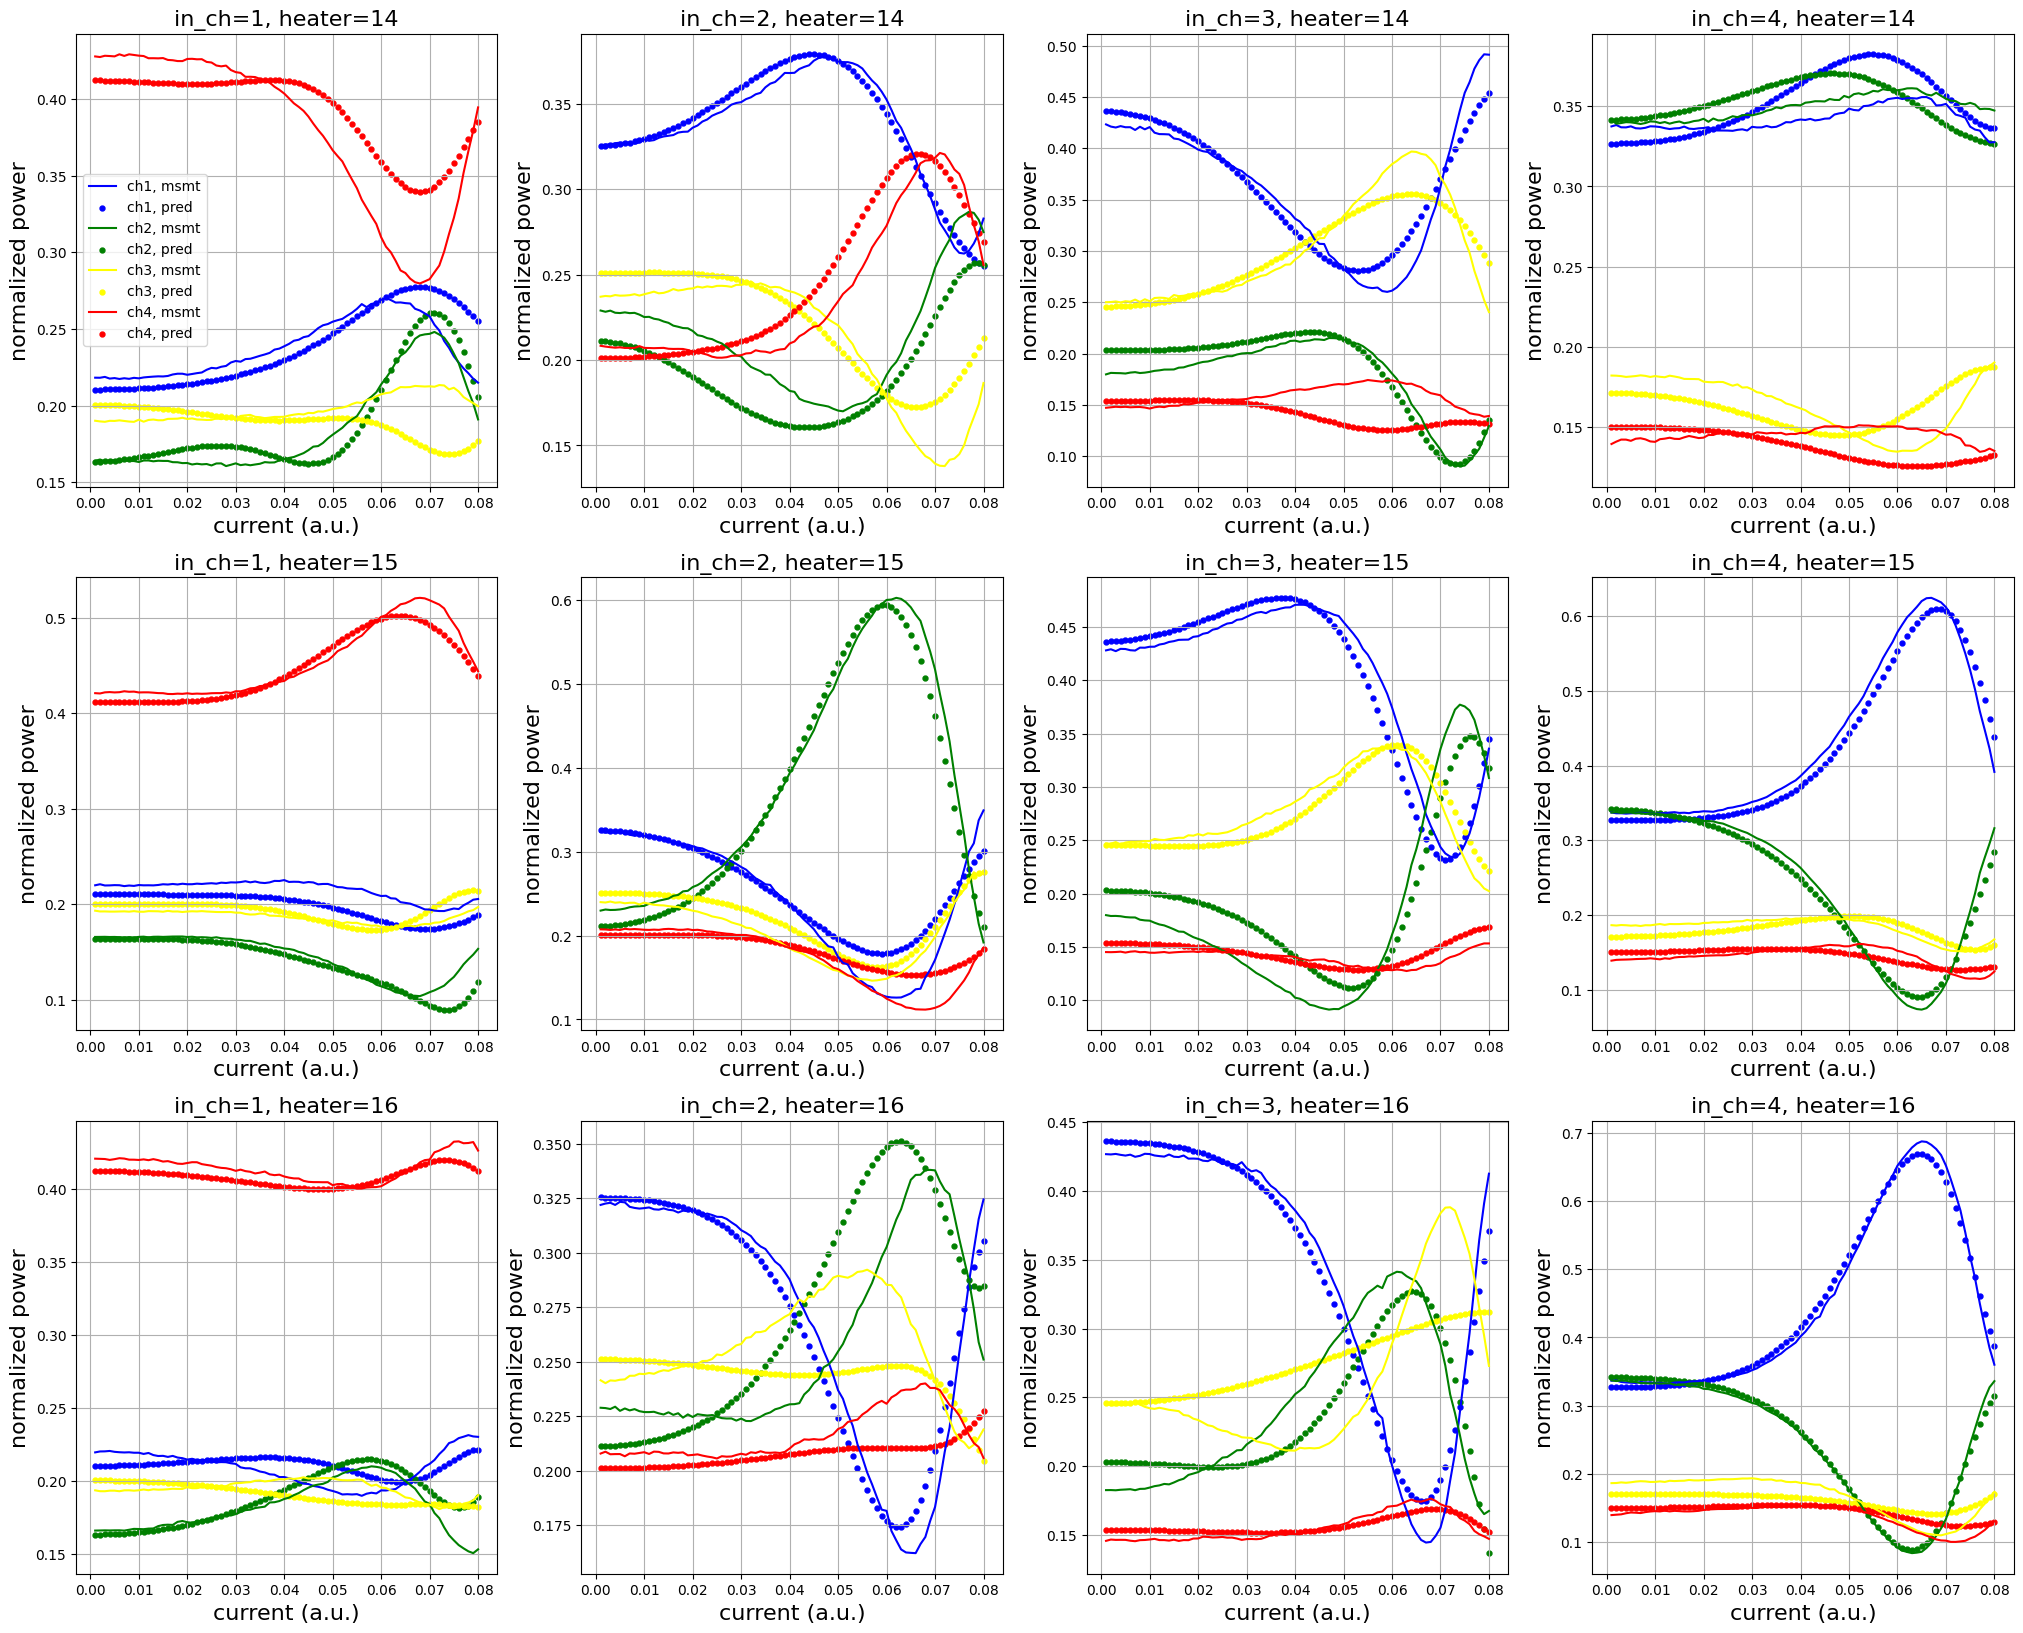

In [32]:
pred = model(x_all, indx)

df['ch1_pred'] = pred[:, 0].detach().cpu().numpy()
df['ch2_pred'] = pred[:, 1].detach().cpu().numpy()
df['ch3_pred'] = pred[:, 2].detach().cpu().numpy()
df['ch4_pred'] = pred[:, 3].detach().cpu().numpy()

fig, ax = plt.subplots(3, 4, figsize=(25, 20))
for j in range(4):
    for i in range(3):
        df_part = df[(df['in_ch']==j) &  (df['heater']==i)]
        for col_true, col_pred, color in zip(
            ['ch1', 'ch2', 'ch3', 'ch4'],
            ['ch1_pred', 'ch2_pred', 'ch3_pred', 'ch4_pred'],
            ['blue', 'green', 'yellow', 'red'],
        ):
            ax[i][j].plot(
                df_part['current'], df_part[col_true],
                label=f"{col_true}, msmt", color=color, alpha=1
            )
            ax[i][j].scatter(
                df_part['current'], df_part[col_pred], marker='.', s=50,
                color=color,label=f"{col_true}, pred"
            )
        ax[i][j].set_title(f'in_ch={j+1}, heater={i+14}',fontsize=16)
        ax[i][j].set_xlabel('current (a.u.)', fontsize=16)
        ax[i][j].set_ylabel('normalized power', fontsize=16)
        ax[i][j].grid()
ax[0][0].legend()
plt.show()